In [2]:
import torch
import psutil
import shutil

print(f"GPU name is {torch.cuda.get_device_name(0)}")
print(f"GPU memory is {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

# get availabe RAM
print(f"Available RAM is {psutil.virtual_memory().available / 1024**3:.2f} GB")
# get storage   
total, used, free = shutil.disk_usage("/")
print(f"Total storage is {total / 1024**3:.2f} GB")
print(f"Used storage is {used / 1024**3:.2f} GB")
print(f"Free storage is {free / 1024**3:.2f} GB")


GPU name is NVIDIA GeForce GTX 1660 Ti
GPU memory is 6.00 GB
Available RAM is 11.13 GB
Total storage is 1006.85 GB
Used storage is 14.06 GB
Free storage is 941.57 GB


# Define Tokenizer

In [1]:
from transformers import AutoTokenizer

model_ckpt = "bert-base-uncased"
text =   "time flies like an arrow"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/home/ossamaak0/miniconda3/envs/main/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
inputs = tokenizer(text, return_tensors="pt", add_special_tokens=False)
inputs.input_ids

tensor([[ 2051, 10029,  2066,  2019,  8612]])

# Embedding Layer

In [23]:
from torch import nn
from transformers import AutoConfig

model_ckpt = "bert-base-uncased"
config = AutoConfig.from_pretrained(model_ckpt)
token_emb = nn.Embedding(config.vocab_size, config.hidden_size)
token_emb

Embedding(30522, 768)

In [28]:
inputs_embeds = token_emb(inputs.input_ids)
inputs_embeds.shape  # batch_size, seq_len, hidden_dim

torch.Size([1, 5, 768])

# Attention

## Scaled Dot Product Attention

In [5]:
import torch
import torch.nn.functional as F
from math import sqrt

query = key = value = inputs_embeds
dim_k = key.shape[-1]
scores = (query @ key.transpose(1, 2)) / sqrt(dim_k)
print(f"Scores shape: {scores.shape}")

# Apply softmax
weights = F.softmax(scores, dim=-1)
print(f"Weights sum: {weights.sum(dim=-1)}")

# multiply by value:
attn_outputs = torch.bmm(weights, value)
attn_outputs.shape

Scores shape: torch.Size([1, 5, 5])
Weights sum: tensor([[1., 1., 1., 1., 1.]], grad_fn=<SumBackward1>)


torch.Size([1, 5, 768])

In [6]:
# Combined into function
def scaled_dot_product_attention(query, key, value):
    scores = (query @ key.transpose(1, 2)) / sqrt(key.shape[-1])
    weights = F.softmax(scores, dim=-1)
    return torch.bmm(weights, value)

## Multi Head Attention

In [7]:
class AttentionHead(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        self.q = nn.Linear(embed_dim, head_dim)
        self.k = nn.Linear(embed_dim, head_dim)
        self.v = nn.Linear(embed_dim, head_dim)

    def forward(self, hidden_state):
        attn_outputs = scaled_dot_product_attention(
            self.q(hidden_state), self.k(hidden_state), self.v(hidden_state)
        )
        return attn_outputs

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        embed_dim = config.hidden_size
        num_heads = config.num_attention_heads
        head_dim = embed_dim // num_heads
        print(f"embed_dim: {embed_dim} | num_heads: {num_heads} | head_dim: {head_dim}")
        self.heads = nn.ModuleList(
            [AttentionHead(embed_dim, head_dim) for _ in range(num_heads)]
        )
        self.output_linear = nn.Linear(embed_dim, embed_dim)

    def forward(self, hidden_state):
        print(f"Attention head output shape: {self.heads[0](hidden_state).shape}")
        x = torch.cat([h(hidden_state) for h in self.heads], dim=-1)
        print("Concatenated attention head output shape:", x.shape)
        x = self.output_linear(x)
        return x

In [9]:
multihead_attn = MultiHeadAttention(config)
print(f"Shape of input_embeds: {inputs_embeds.shape}")
attn_output = multihead_attn(inputs_embeds)

embed_dim: 768 | num_heads: 12 | head_dim: 64
Shape of input_embeds: torch.Size([1, 5, 768])
Attention head output shape: torch.Size([1, 5, 64])
Concatenated attention head output shape: torch.Size([1, 5, 768])


# Visualization

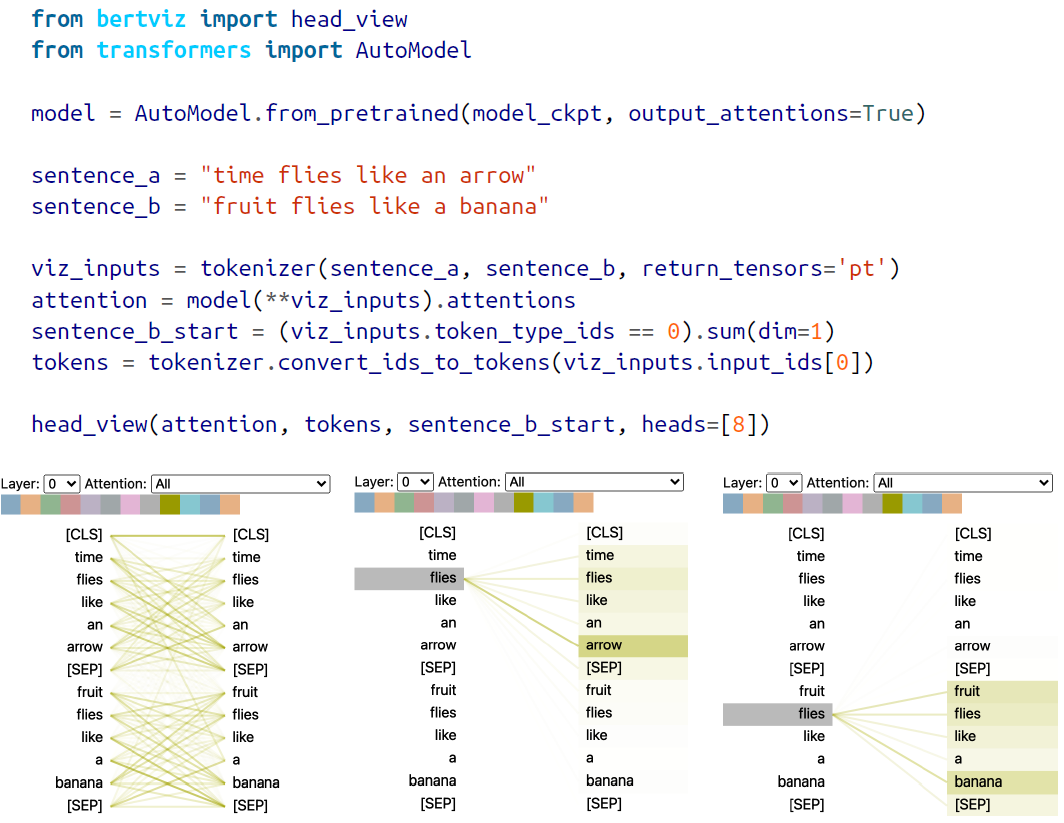

# FeedForward

In [10]:
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        print(
            f"hidden_size: {config.hidden_size} | itermediate_size: {config.intermediate_size}"
        )
        self.linear_1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.linear_2 = nn.Linear(config.intermediate_size, config.hidden_size)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.gelu(x)
        x = self.linear_2(x)
        x = self.dropout(x)
        return x

In [11]:
feed_forward = FeedForward(config)
ff_outputs = feed_forward(attn_outputs)
ff_outputs.size()

hidden_size: 768 | itermediate_size: 3072


torch.Size([1, 5, 768])

# Encoder Block

In [12]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(config.hidden_size)
        self.layer_norm_2 = nn.LayerNorm(config.hidden_size)
        self.attention = MultiHeadAttention(config)
        self.feed_forward = FeedForward(config)

    def forward(self, x):
        # Apply layer normalization and then copy input into query, key, value
        hidden_state = self.layer_norm_1(x)
        # Apply attention with a skip connection
        x = x + self.attention(hidden_state)
        # Apply feed-forward layer with a skip connection
        x = x + self.feed_forward(self.layer_norm_2(x))
        return x

In [19]:
encoder_layer = TransformerEncoderLayer(config)
encoder_layer_outputs = encoder_layer(inputs_embeds)
print("*" * 75)
print(f"Shape of input embeddings: {inputs_embeds.shape}")
print(f"Shape of encoder layer output: {encoder_layer_outputs.shape}")

embed_dim: 768 | num_heads: 12 | head_dim: 64
hidden_size: 768 | itermediate_size: 3072
Attention head output shape: torch.Size([1, 5, 64])
Concatenated attention head output shape: torch.Size([1, 5, 768])
***************************************************************************
Shape of input embeddings: torch.Size([1, 5, 768])
Shape of encoder layer output: torch.Size([1, 5, 768])


# Positional Embeddings

In [57]:
class Embeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_embeddings = nn.Embedding(config.vocab_size, config.hidden_size)
        self.position_embeddings = nn.Embedding(
            config.max_position_embeddings, config.hidden_size
        )
        self.layer_norm = nn.LayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout()

    def forward(self, input_ids):
        # Create position IDs for input sequence
        seq_length = input_ids.size(1)
        print(f"seq_length shape: {seq_length}")
        position_ids = torch.arange(seq_length, dtype=torch.long).unsqueeze(0)
        print(f"positional_ids: {position_ids}")
        # Create token and position embeddings
        token_embeddings = self.token_embeddings(input_ids)
        print(f"Shape of token embeddings: {token_embeddings.shape}")
        position_embeddings = self.position_embeddings(position_ids)
        print(f"Shape of position embeddings: {position_embeddings.shape}")
        # Combine token and position embeddings
        embeddings = token_embeddings + position_embeddings
        embeddings = self.layer_norm(embeddings)
        embeddings = self.dropout(embeddings)

        return embeddings

In [58]:
embedding_layer = Embeddings(config)
embeddings = embedding_layer(inputs.input_ids)
print(f"Embeddings shape: {embeddings.shape}")

shape of position_embeddings: torch.Size([512, 768])
seq_length shape: 5
positional_ids: tensor([[0, 1, 2, 3, 4]])
Shape of token embeddings: torch.Size([1, 5, 768])
Shape of position embeddings: torch.Size([1, 5, 768])
Embeddings shape: torch.Size([1, 5, 768])


# Final Architecture
you can add a classification layer on top of the encoder output to use it for classification tasks.

In [64]:
class TransformerEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embeddings = Embeddings(config)
        self.layers = nn.ModuleList(
            [TransformerEncoderLayer(config) for _ in range(config.num_hidden_layers)]
        )

    def forward(self, x):
        x = self.embeddings(x)
        for layer in self.layers:
            x = layer(x)
        return x

In [65]:
encoder = TransformerEncoder(config)
encoder(inputs.input_ids).shape

shape of position_embeddings: torch.Size([512, 768])
embed_dim: 768 | num_heads: 12 | head_dim: 64
hidden_size: 768 | itermediate_size: 3072
embed_dim: 768 | num_heads: 12 | head_dim: 64
hidden_size: 768 | itermediate_size: 3072
embed_dim: 768 | num_heads: 12 | head_dim: 64
hidden_size: 768 | itermediate_size: 3072
embed_dim: 768 | num_heads: 12 | head_dim: 64
hidden_size: 768 | itermediate_size: 3072
embed_dim: 768 | num_heads: 12 | head_dim: 64
hidden_size: 768 | itermediate_size: 3072
embed_dim: 768 | num_heads: 12 | head_dim: 64
hidden_size: 768 | itermediate_size: 3072
embed_dim: 768 | num_heads: 12 | head_dim: 64
hidden_size: 768 | itermediate_size: 3072
embed_dim: 768 | num_heads: 12 | head_dim: 64
hidden_size: 768 | itermediate_size: 3072
embed_dim: 768 | num_heads: 12 | head_dim: 64
hidden_size: 768 | itermediate_size: 3072
embed_dim: 768 | num_heads: 12 | head_dim: 64
hidden_size: 768 | itermediate_size: 3072
embed_dim: 768 | num_heads: 12 | head_dim: 64
hidden_size: 768 | it

torch.Size([1, 5, 768])